# 1. Install Dependencies and Setup

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = '/content/drive/MyDrive/datanew'

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/datanew')

Found 307 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

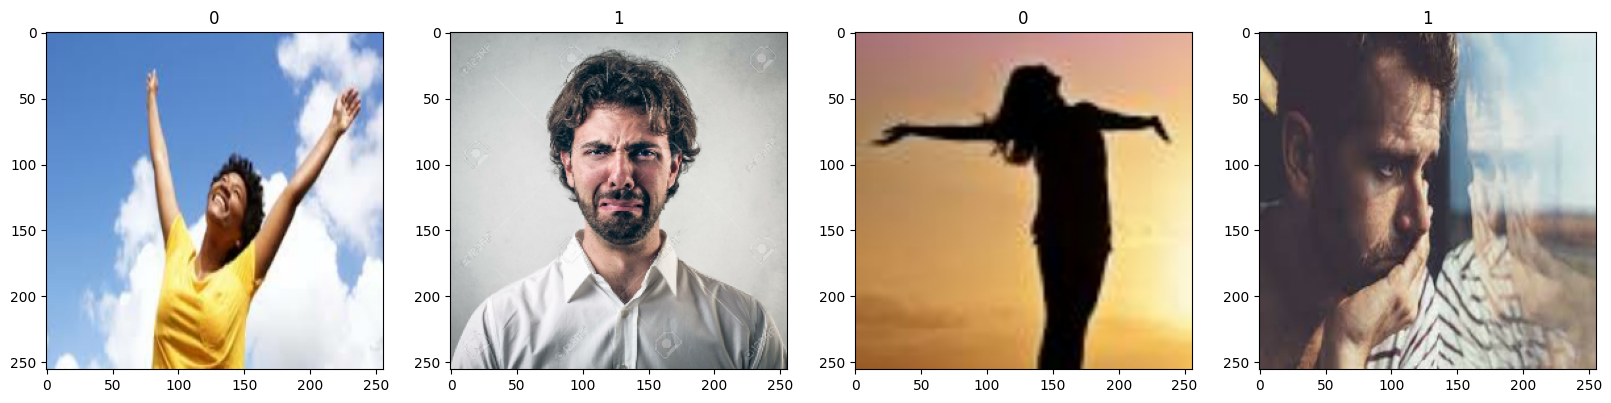

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.12981005, 0.13765319, 0.13373162],
          [0.14748774, 0.15533088, 0.15140931],
          [0.1513174 , 0.15916054, 0.15523897],
          ...,
          [0.20033701, 0.20818014, 0.20425858],
          [0.225     , 0.23284313, 0.22892156],
          [0.13526349, 0.14310662, 0.13918506]],
 
         [[0.15481006, 0.1626532 , 0.15873162],
          [0.14800858, 0.15585172, 0.15193015],
          [0.15199143, 0.15983456, 0.155913  ],
          ...,
          [0.12772672, 0.13556986, 0.13164829],
          [0.13002451, 0.13786764, 0.13394608],
          [0.15242034, 0.16026348, 0.15634191]],
 
         [[0.16822916, 0.1760723 , 0.17215073],
          [0.17349878, 0.18134192, 0.17742035],
          [0.17120098, 0.17904411, 0.17512254],
          ...,
          [0.14332108, 0.15116422, 0.14724265],
          [0.14500612, 0.15284927, 0.1489277 ],
          [0.14175858, 0.14960171, 0.14568014]],
 
         ...,
 
         [[0.1764706 , 0.18431373, 0.18039216],
          [0.17647

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
7/7 [==============================] - 33s 4s/step - loss: 0.6066 - accuracy: 0.7188 - val_loss: 0.4338 - val_accuracy: 0.8438
Epoch 2/5
7/7 [==============================] - 28s 3s/step - loss: 0.5197 - accuracy: 0.8348 - val_loss: 0.4755 - val_accuracy: 0.8438
Epoch 3/5
7/7 [==============================] - 32s 4s/step - loss: 0.4230 - accuracy: 0.8348 - val_loss: 0.3944 - val_accuracy: 0.8125
Epoch 4/5
7/7 [==============================] - 32s 4s/step - loss: 0.3538 - accuracy: 0.8527 - val_loss: 0.1976 - val_accuracy: 0.9375
Epoch 5/5
7/7 [==============================] - 31s 4s/step - loss: 0.2951 - accuracy: 0.8661 - val_loss: 0.3554 - val_accuracy: 0.8750


# 8. Plot Performance

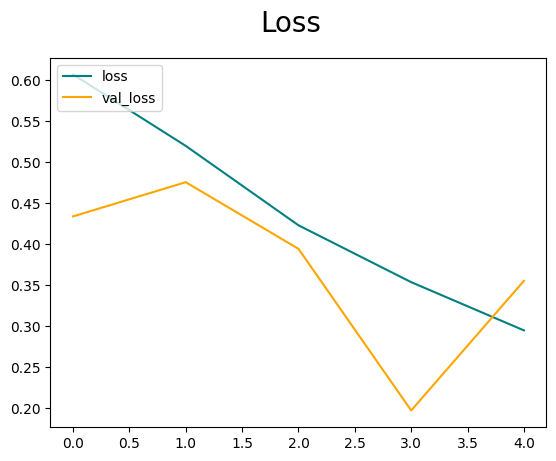

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

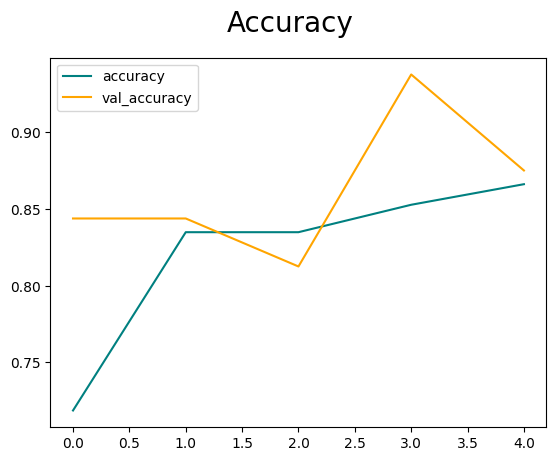

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 459ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.8181818, shape=(), dtype=float32) tf.Tensor(0.8947368, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

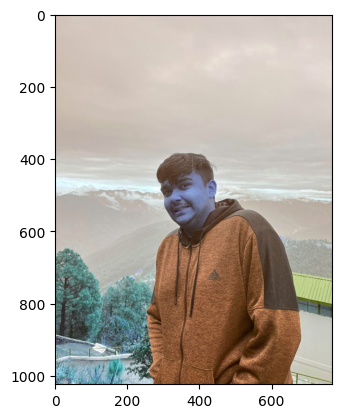

In [46]:
img = cv2.imread('/content/drive/MyDrive/WhatsApp Image 2023-08-20 at 17.34.43.jpeg')
plt.imshow(img)
plt.show()

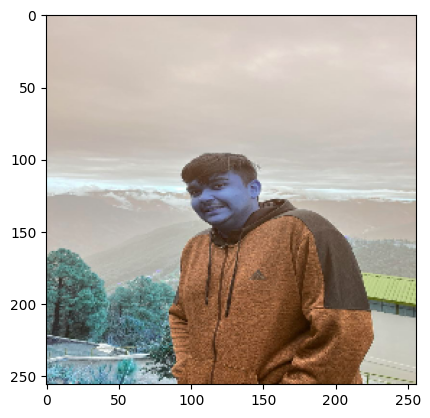

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 89ms/step


In [49]:
yhat

array([[0.52744395]], dtype=float32)

In [50]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)